Epoch 20/100, Loss: 0.00239
Epoch 40/100, Loss: 0.00242
Epoch 60/100, Loss: 0.00172
Epoch 80/100, Loss: 0.00283
Epoch 100/100, Loss: 0.00203
Epoch 20/100, Loss: 0.00253
Epoch 40/100, Loss: 0.00281
Epoch 60/100, Loss: 0.00115
Epoch 80/100, Loss: 0.00086
Epoch 100/100, Loss: 0.00081


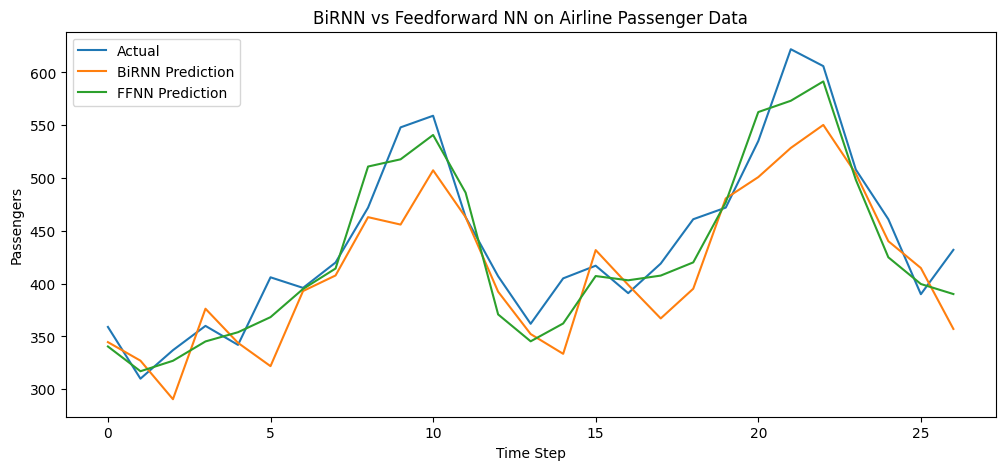

BiRNN MSE: 1994.991
FFNN MSE: 654.457


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preparation
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv';
df = pd.read_csv(url, usecols=[1])
data = df.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

SEQ_LENGTH = 10
X = np.array([data_scaled[i:i+SEQ_LENGTH] for i in range(len(data_scaled) - SEQ_LENGTH)])
y = np.array([data_scaled[i + SEQ_LENGTH] for i in range(len(data_scaled) - SEQ_LENGTH)])

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=1)

# Define BiRNN Model
class BiRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(BiRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# Define Feedforward Neural Network Model
class FeedforwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten sequence for feedforward NN
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Training function
def train_model(model, loader, epochs=100):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        loss_epoch = 0
        for seqs, targets in loader:
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_epoch / len(loader):.5f}")

# Evaluation function
def evaluate_model(model, X):
    model.eval()
    with torch.no_grad():
        return model(X).numpy()

# Instantiate and train models
birnn = BiRNN()
train_model(birnn, train_loader)

ffnn = FeedforwardNN(input_size=SEQ_LENGTH)
train_model(ffnn, train_loader)

# Predict on test set
pred_birnn = evaluate_model(birnn, X_test_tensor)
pred_ffnn = evaluate_model(ffnn, X_test_tensor)

# Inverse scale predictions and true values
pred_birnn_inv = scaler.inverse_transform(pred_birnn)
pred_ffnn_inv = scaler.inverse_transform(pred_ffnn)
y_test_inv = scaler.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_birnn_inv, label='BiRNN Prediction')
plt.plot(pred_ffnn_inv, label='FFNN Prediction')
plt.legend()
plt.title('BiRNN vs Feedforward NN on Airline Passenger Data')
plt.xlabel('Time Step')
plt.ylabel('Passengers')
plt.show()

# Calculate and print MSE
mse_birnn = mean_squared_error(y_test_inv, pred_birnn_inv)
mse_ffnn = mean_squared_error(y_test_inv, pred_ffnn_inv)
print(f"BiRNN MSE: {mse_birnn:.3f}")
print(f"FFNN MSE: {mse_ffnn:.3f}")